# ポートフォリオ「電力消費予測 深層学習 RayTuneチューニング」（仲本夏生）

## RayTuneを用いてのチューニング結果

- 本ノートブックは、深層学習（RNN、LSTM、GRU）を用いた電力消費予測の前回のポートフォリオをベースに、Ray Tune によるハイパーパラメータチューニングの結果を示したものである。
- 調整対象のパラメータとその調整方法は以下のとおり。
    - 隠れユニット数（`hidden_size`）：64、128、256 の中からランダムに選択
    - 学習率（`learning_rate`）: $10^{-4}$から$10^{-2}$の範囲で対数スケールの一様分布に従う浮動小数点数から選択
    - ドロップアウト（`dropout`）: 0.0~0.5の範囲で一様分布に従う浮動小数点数から選択
    - バッチサイズ（`batch_size`）: 64 または 128 のいずれかをランダムに選択

### 前処理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_csv("./data/data.csv")
df = df.ffill()
df

,DATETIME,10MW,temperature,temperature_abs,is_holiday
0,2016/4/1 0:00,2555,14.5,3.6,0
1,2016/4/1 1:00,2433,13.3,4.8,0
2,2016/4/1 2:00,2393,13.8,4.3,0
3,2016/4/1 3:00,2375,13.0,5.1,0
4,2016/4/1 4:00,2390,12.2,5.9,0
...,...,...,...,...,...
67939,2023/12/31 19:00,2919,9.6,8.5,1
67940,2023/12/31 20:00,2845,11.4,6.7,1
67941,2023/12/31 21:00,2754,11.0,7.1,1
67942,2023/12/31 22:00,2647,9.5,8.6,1


In [3]:
df['DATETIME'] = pd.to_datetime(df['DATETIME'])

In [4]:
import datetime as dt
df["year"] = df['DATETIME'].dt.year
df["month"] = df['DATETIME'].dt.month
df["hour"] = df['DATETIME'].dt.hour

In [5]:
train_df = df[(df['DATETIME'] >= dt.datetime(2016,4,1)) & (df['DATETIME'] < dt.datetime(2022,12,31))].reset_index(drop=True)
test_df = df[(df['DATETIME'] >= dt.datetime(2023,1,1)) & (df['DATETIME'] < dt.datetime(2023,12,31))].reset_index(drop=True)

In [6]:
train_df = train_df.drop(columns='DATETIME')
test_df = test_df.drop(columns='DATETIME')

In [7]:
y_train = train_df['10MW']
y_test = test_df['10MW']
X_train = train_df.drop(columns='10MW')
X_test = test_df.drop(columns='10MW')

In [8]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(59160, 6) (59160,) (8736, 6) (8736,)


In [9]:
# MinMaxScalerを使って特徴量とターゲットを 0〜1 にスケーリング
from sklearn.preprocessing import MinMaxScaler

# MinMaxScalerを適用
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# X_train, X_test のスケーリング
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
# y_train, y_test のスケーリング (1次元 → 2次元にreshape)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
# LSTM/RNNモデルの学習や予測では、y_train_scaled が 2次元 (n_samples, 1) のまま使えるので、flattenは不要

In [10]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_train_scaled shape:", y_train_scaled.shape)
print("y_test_scaled shape:", y_test_scaled.shape)

X_train_scaled shape: (59160, 6)
X_test_scaled shape: (8736, 6)
y_train_scaled shape: (59160, 1)
y_test_scaled shape: (8736, 1)


In [11]:
data_train = torch.tensor(X_train_scaled, dtype=torch.float32)
data_test = torch.tensor(X_test_scaled, dtype=torch.float32)
targets_train = torch.tensor(y_train_scaled, dtype=torch.float32)
targets_test = torch.tensor(y_test_scaled, dtype=torch.float32)

In [12]:
# モデルに適した形状に変換する
def create_sequences(data, targets, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length] # モデルの入力
        label = targets[i+sequence_length] # 予測すべき次の値
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

# 過去の一定期間（24時間分）のデータを1つの入力シーケンとしてまとめる
sequence_length = 24

# シーケンスデータ作成
train_sequences, train_labels = create_sequences(data_train, targets_train, sequence_length)
test_sequences, test_labels = create_sequences(data_test, targets_test, sequence_length)

print(train_sequences.shape)  # (n_samples, sequence_length, num_features)
print(train_labels.shape)     # (n_samples, 1)

torch.Size([59136, 24, 6])
torch.Size([59136, 1])


In [13]:
def create_dataloaders(batch_size):
    train_dataset = TensorDataset(train_sequences, train_labels)
    test_dataset = TensorDataset(test_sequences, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # サンプルデータを1バッチ取得して形状を確認
    for batch_x, batch_y in train_loader:
        print(f"Sample train_loader batch_x shape: {batch_x.shape}")
        print(f"Sample train_loader batch_y shape: {batch_y.shape}")
        break
    for batch_x, batch_y in test_loader:
        print(f"Sample test_loader batch_x shape: {batch_x.shape}")
        print(f"Sample test_loader batch_y shape: {batch_y.shape}")
        break

    return train_loader, test_loader

In [14]:
import torch
print('torch version:', torch.__version__)
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

torch version: 2.7.0+cu126
GPU Available: True
GPU Name: NVIDIA GeForce RTX 4070 Ti SUPER


In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.air import RunConfig, session
from ray.train import ScalingConfig
from ray.tune import ExperimentAnalysis

import numpy as np
import random
import os
from sklearn.metrics import mean_squared_error, r2_score

### RNN RayTune結果

In [16]:
# 乱数シード設定
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.0):
        super(RNNModel, self).__init__()
        if num_layers == 1:  # 層が1つの場合はdropoutを無効化
            dropout = 0.0
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

#### RNN 1層

In [ ]:
exp_name = "RNN_tune_1"
storage_path = os.path.abspath("ray_results")
experiment_path = os.path.join(storage_path, exp_name) # 実験ディレクトリのパスを指定
os.makedirs(experiment_path, exist_ok=True) # すでにディレクトリが存在している場合はスキップ

# ハイパーパラメータ探索範囲
config = {
    "hidden_size": tune.choice([64, 128, 256]),
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "dropout": tune.uniform(0.0, 0.5),
    "batch_size": tune.choice([64, 128]),
    "num_epochs": 30
}

# 試行スケジューラ定義
ray_scheduler = ASHAScheduler(
    max_t=30,
    grace_period=5,
    reduction_factor=2
)

def train_rnn_model(config):
    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader = create_dataloaders(config["batch_size"])

    model = RNNModel(
        input_size=6,  # 特徴量数に合わせる
        hidden_size=config["hidden_size"],
        output_size=1,  # 出力サイズ
        num_layers=1, # ここを変える
        dropout=config["dropout"]
    ).to(device)  # モデルをGPUに送る

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    best_test_loss = float("inf")
    best_epoch = 0
    best_model_state = None

    for epoch in range(config["num_epochs"]):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets = [], []
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 入力データをGPUに送る

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_predictions.append(outputs.cpu())  # CPUに戻す
            train_targets.append(batch_y.cpu())

        train_loss /= len(train_loader)
        train_predictions = scaler_y.inverse_transform(torch.cat(train_predictions).detach().numpy()) # 勾配追跡を無効化
        train_targets = scaler_y.inverse_transform(torch.cat(train_targets).detach().numpy())
        train_rmse = np.sqrt(mean_squared_error(train_targets, train_predictions))

        model.eval()
        test_loss = 0.0
        test_predictions, test_targets = [], []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
                test_predictions.append(outputs.cpu())  # CPUに戻す
                test_targets.append(batch_y.cpu())

        test_loss /= len(test_loader)
        test_predictions = scaler_y.inverse_transform(torch.cat(test_predictions).detach().numpy())
        test_targets = scaler_y.inverse_transform(torch.cat(test_targets).detach().numpy())
        test_rmse = np.sqrt(mean_squared_error(test_targets, test_predictions))
        test_r2 = r2_score(test_targets, test_predictions)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_epoch = epoch
            best_model_state = model.state_dict()

        # 学習率スケジューラを更新
        scheduler.step()

        # 結果を報告
        tune.report({"train_loss": train_loss, "train_rmse": train_rmse,
                        "test_loss": test_loss, "test_rmse": test_rmse,
                        "test_r2": test_r2,
                        "epoch": epoch, "best_test_loss": best_test_loss, "best_epoch":best_epoch})

    torch.save(best_model_state, os.path.join(experiment_path, "best_model.path"))

algo = OptunaSearch(metric="test_loss", mode="min")

# リソース設定
scaling_config = ScalingConfig(
    num_workers=-2,              # 試行ごとに使用するワーカー数
    use_gpu=True,               # GPUを使用
    trainer_resources={"cpu": 4, "gpu": 1},  # トレーナーが使用するリソース
)
trainable_with_cpu_gpu = tune.with_resources(train_rnn_model, {"cpu": 4, "gpu": 1})
tuner = tune.Tuner(
    trainable_with_cpu_gpu,
    tune_config=tune.TuneConfig(
        metric="test_loss",
        mode="min",
        num_samples=30,
        search_alg=algo,
        scheduler=ray_scheduler,
        max_concurrent_trials=5
    ),
    run_config=RunConfig(
        storage_path=experiment_path,
        verbose=1,
    ),
    param_space=config,
)
result_grid = tuner.fit()
best_result = result_grid.get_best_result()

(raylet) Warning: The actor ImplicitFunc is very large (37 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(train_rnn_model pid=47895) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_rnn_model pid=47895) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_rnn_model pid=47895) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_rnn_model pid=47895) Sample test_loader batch_y shape: torch.Size([64, 1])
(train_rnn_model pid=48207) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_rnn_model pid=48207) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_rnn_model pid=48207) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_rnn_model pid=48207) Sample test_loader batch_y shape: torch.Size([64, 1])
(train_rnn_model pid=48319) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_rnn_mo

2025-05-25 00:48:45,141	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/omen/Projects/2505_portfolio_r/ray_results/RNN_tune_1/train_rnn_model_2025-05-25_00-35-32' in 0.0059s.
2025-05-25 00:48:45,148	INFO tune.py:1041 -- Total run time: 790.62 seconds (790.34 seconds for the tuning loop).


(raylet) Warning: The actor ImplicitFunc is very large (37 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(train_lstm1_model pid=52612) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30889711256534197 and num_layers=1
(train_lstm1_model pid=52612)   warnings.warn(


(train_lstm1_model pid=52612) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=52612) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_lstm1_model pid=52612) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=52612) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_lstm1_model pid=52787) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4990469557519696 and num_layers=1
(train_lstm1_model pid=52787)   warnings.warn(


(train_lstm1_model pid=52787) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=52787) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_lstm1_model pid=52787) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=52787) Sample test_loader batch_y shape: torch.Size([128, 1])
(train_lstm1_model pid=52893) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=52893) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=52893) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=52893) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=52893) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4765715134203342 and num_layers=1
(train_lstm1_model pid=52893)   warnings.warn(
(train_lstm1_model pid=53024) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23032128447796169 and num_layers=1
(train_lstm1_model pid=53024)   warnings.warn(


(train_lstm1_model pid=53024) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53024) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_lstm1_model pid=53024) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53024) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_lstm1_model pid=53130) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19821460757960463 and num_layers=1
(train_lstm1_model pid=53130)   warnings.warn(


(train_lstm1_model pid=53130) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=53130) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=53130) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=53130) Sample test_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=53237) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53237) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_lstm1_model pid=53237) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53237) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_lstm1_model pid=53237) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23188617234615683 and num_layers=1
(train_lstm1_model pid=53237)   warnings.warn(
(train_lstm1_model pid=53330) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10452043385361542 and num_layers=1
(train_lstm1_model pid=53330)   warnings.warn(


(train_lstm1_model pid=53330) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53330) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_lstm1_model pid=53330) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53330) Sample test_loader batch_y shape: torch.Size([128, 1])
(train_lstm1_model pid=53424) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53424) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_lstm1_model pid=53424) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53424) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_lstm1_model pid=53424) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.08265661313913014 and num_layers=1
(train_lstm1_model pid=53424)   warnings.warn(
(train_lstm1_model pid=53530) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.48286385359197764 and num_layers=1
(train_lstm1_model pid=53530)   warnings.warn(


(train_lstm1_model pid=53530) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53530) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_lstm1_model pid=53530) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53530) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_lstm1_model pid=53630) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4870478156724884 and num_layers=1
(train_lstm1_model pid=53630)   warnings.warn(


(train_lstm1_model pid=53630) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53630) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_lstm1_model pid=53630) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53630) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_lstm1_model pid=53780) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4049880230368632 and num_layers=1
(train_lstm1_model pid=53780)   warnings.warn(


(train_lstm1_model pid=53780) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53780) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_lstm1_model pid=53780) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_lstm1_model pid=53780) Sample test_loader batch_y shape: torch.Size([128, 1])
(train_lstm1_model pid=53880) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=53880) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=53880) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=53880) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=53880) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.34236968376294497 and num_layers=1
(train_lstm1_model pid=53880)   warnings.warn(
(train_lstm1_model pid=54168) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2108321153143544 and num_layers=1
(train_lstm1_model pid=54168)   warnings.warn(


(train_lstm1_model pid=54168) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=54168) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=54168) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=54168) Sample test_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=54274) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=54274) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=54274) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=54274) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=54274) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32135365502964364 and num_layers=1
(train_lstm1_model pid=54274)   warnings.warn(


(train_lstm1_model pid=54493) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=54493) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=54493) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=54493) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=54493) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3361689659181704 and num_layers=1
(train_lstm1_model pid=54493)   warnings.warn(


(train_lstm1_model pid=54718) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=54718) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=54718) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=54718) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=54718) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32753993198510223 and num_layers=1
(train_lstm1_model pid=54718)   warnings.warn(
(train_lstm1_model pid=54830) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12920479070321794 and num_layers=1
(train_lstm1_model pid=54830)   warnings.warn(


(train_lstm1_model pid=54830) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=54830) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=54830) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=54830) Sample test_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=55132) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=55132) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=55132) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=55132) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=55132) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16343784675355633 and num_layers=1
(train_lstm1_model pid=55132)   warnings.warn(


(train_lstm1_model pid=55419) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=55419) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=55419) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=55419) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=55419) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.02071036206803767 and num_layers=1
(train_lstm1_model pid=55419)   warnings.warn(


(train_lstm1_model pid=55546) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=55546) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=55546) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=55546) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=55546) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0007944193725171189 and num_layers=1
(train_lstm1_model pid=55546)   warnings.warn(
(train_lstm1_model pid=55664) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.13779437677657655 and num_layers=1
(train_lstm1_model pid=55664)   warnings.warn(


(train_lstm1_model pid=55664) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=55664) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=55664) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=55664) Sample test_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=55780) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=55780) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=55780) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=55780) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=55780) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14134570145386308 and num_layers=1
(train_lstm1_model pid=55780)   warnings.warn(


(train_lstm1_model pid=55895) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=55895) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=55895) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=55895) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=55895) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1578652887011048 and num_layers=1
(train_lstm1_model pid=55895)   warnings.warn(


(train_lstm1_model pid=56194) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=56194) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=56194) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=56194) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=56194) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17057002901095947 and num_layers=1
(train_lstm1_model pid=56194)   warnings.warn(


(train_lstm1_model pid=56482) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=56482) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=56482) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=56482) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=56482) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16555315028945927 and num_layers=1
(train_lstm1_model pid=56482)   warnings.warn(
(train_lstm1_model pid=56772) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05095255638920146 and num_layers=1
(train_lstm1_model pid=56772)   warnings.warn(


(train_lstm1_model pid=56772) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=56772) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=56772) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=56772) Sample test_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=56931) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=56931) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=56931) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=56931) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=56931) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.06454837104138907 and num_layers=1
(train_lstm1_model pid=56931)   warnings.warn(


(train_lstm1_model pid=57083) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=57083) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=57083) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=57083) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=57083) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.27882932174417047 and num_layers=1
(train_lstm1_model pid=57083)   warnings.warn(
(train_lstm1_model pid=57201) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2663008658954891 and num_layers=1
(train_lstm1_model pid=57201)   warnings.warn(


(train_lstm1_model pid=57201) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=57201) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=57201) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=57201) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_lstm1_model pid=57319) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17954429737761401 and num_layers=1
(train_lstm1_model pid=57319)   warnings.warn(


(train_lstm1_model pid=57319) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=57319) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm1_model pid=57319) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm1_model pid=57319) Sample test_loader batch_y shape: torch.Size([64, 1])
(raylet) Warning: The actor ImplicitFunc is very large (37 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(train_lstm2_model pid=57426) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm2_model pid=57426) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_lstm2_model pid=57426) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_lstm2_model pid=57426) Sample test_loader batch_y shape: torch.Size([64, 1])
(train_lstm2_model pid=57701) Sample train_loader batch_x shape: torch.Size([64, 24,

(train_gru1_model pid=61536) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.26695443590934936 and num_layers=1
(train_gru1_model pid=61536)   warnings.warn(
(train_gru1_model pid=61773) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.31607570325176015 and num_layers=1
(train_gru1_model pid=61773)   warnings.warn(


(train_gru1_model pid=61773) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=61773) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_gru1_model pid=61773) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=61773) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_gru1_model pid=61898) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.483339684759862 and num_layers=1
(train_gru1_model pid=61898)   warnings.warn(


(train_gru1_model pid=61898) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=61898) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_gru1_model pid=61898) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=61898) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_gru1_model pid=62004) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.41516931512504773 and num_layers=1
(train_gru1_model pid=62004)   warnings.warn(


(train_gru1_model pid=62004) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=62004) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=62004) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=62004) Sample test_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=62104) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=62104) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_gru1_model pid=62104) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=62104) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_gru1_model pid=62104) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4319481460004888 and num_layers=1
(train_gru1_model pid=62104)   warnings.warn(


(train_gru1_model pid=62241) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=62241) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=62241) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=62241) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_gru1_model pid=62241) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3949096982026997 and num_layers=1
(train_gru1_model pid=62241)   warnings.warn(


(train_gru1_model pid=62370) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=62370) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=62370) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=62370) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_gru1_model pid=62370) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3396898015142606 and num_layers=1
(train_gru1_model pid=62370)   warnings.warn(


(train_gru1_model pid=62482) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=62482) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=62482) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=62482) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_gru1_model pid=62482) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16716010749135168 and num_layers=1
(train_gru1_model pid=62482)   warnings.warn(
(train_gru1_model pid=62594) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0871358930422661 and num_layers=1
(train_gru1_model pid=62594)   warnings.warn(


(train_gru1_model pid=62594) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=62594) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_gru1_model pid=62594) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=62594) Sample test_loader batch_y shape: torch.Size([64, 1])
(train_gru1_model pid=62850) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=62850) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_gru1_model pid=62850) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=62850) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_gru1_model pid=62850) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.45833720660445004 and num_layers=1
(train_gru1_model pid=62850)   warnings.warn(
(train_gru1_model pid=62975) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4173546095028717 and num_layers=1
(train_gru1_model pid=62975)   warnings.warn(


(train_gru1_model pid=62975) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=62975) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_gru1_model pid=62975) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=62975) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_gru1_model pid=63216) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.008269384008724678 and num_layers=1
(train_gru1_model pid=63216)   warnings.warn(


(train_gru1_model pid=63216) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=63216) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=63216) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=63216) Sample test_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=63322) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=63322) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=63322) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=63322) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_gru1_model pid=63322) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.054028750414856413 and num_layers=1
(train_gru1_model pid=63322)   warnings.warn(


(train_gru1_model pid=63479) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=63479) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=63479) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=63479) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_gru1_model pid=63479) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.13866741120041365 and num_layers=1
(train_gru1_model pid=63479)   warnings.warn(


(train_gru1_model pid=63672) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=63672) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=63672) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=63672) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_gru1_model pid=63672) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15376375591291883 and num_layers=1
(train_gru1_model pid=63672)   warnings.warn(


(train_gru1_model pid=63785) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=63785) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_gru1_model pid=63785) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=63785) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_gru1_model pid=63785) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17403020577161057 and num_layers=1
(train_gru1_model pid=63785)   warnings.warn(
(train_gru1_model pid=64022) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23416672134053632 and num_layers=1
(train_gru1_model pid=64022)   warnings.warn(


(train_gru1_model pid=64022) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=64022) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_gru1_model pid=64022) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=64022) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_gru1_model pid=64284) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23749202481500029 and num_layers=1
(train_gru1_model pid=64284)   warnings.warn(


(train_gru1_model pid=64284) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=64284) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_gru1_model pid=64284) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=64284) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_gru1_model pid=64397) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.08503836589851033 and num_layers=1
(train_gru1_model pid=64397)   warnings.warn(


(train_gru1_model pid=64397) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=64397) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=64397) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=64397) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_gru1_model pid=64497) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3500759247920525 and num_layers=1
(train_gru1_model pid=64497)   warnings.warn(


(train_gru1_model pid=64497) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=64497) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=64497) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=64497) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_gru1_model pid=64621) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.36722346876649736 and num_layers=1
(train_gru1_model pid=64621)   warnings.warn(


(train_gru1_model pid=64621) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=64621) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=64621) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=64621) Sample test_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=64740) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=64740) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=64740) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=64740) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_gru1_model pid=64740) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3752380996901534 and num_layers=1
(train_gru1_model pid=64740)   warnings.warn(


(train_gru1_model pid=64841) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=64841) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=64841) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=64841) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_gru1_model pid=64841) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3716257484525117 and num_layers=1
(train_gru1_model pid=64841)   warnings.warn(
(train_gru1_model pid=65003) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2834935872705571 and num_layers=1
(train_gru1_model pid=65003)   warnings.warn(


(train_gru1_model pid=65003) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=65003) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=65003) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=65003) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_gru1_model pid=65166) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.27609601469723993 and num_layers=1
(train_gru1_model pid=65166)   warnings.warn(


(train_gru1_model pid=65166) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=65166) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=65166) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=65166) Sample test_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=65322) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=65322) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=65322) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=65322) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_gru1_model pid=65322) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3189387478267029 and num_layers=1
(train_gru1_model pid=65322)   warnings.warn(
(train_gru1_model pid=65428) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3185441439267474 and num_layers=1
(train_gru1_model pid=65428)   warnings.warn(


(train_gru1_model pid=65428) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=65428) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru1_model pid=65428) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru1_model pid=65428) Sample test_loader batch_y shape: torch.Size([128, 1])


(train_gru1_model pid=65528) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2135614605194489 and num_layers=1
(train_gru1_model pid=65528)   warnings.warn(


(train_gru1_model pid=65528) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=65528) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_gru1_model pid=65528) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=65528) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_gru1_model pid=65637) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2063359595847703 and num_layers=1
(train_gru1_model pid=65637)   warnings.warn(


(train_gru1_model pid=65637) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=65637) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_gru1_model pid=65637) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=65637) Sample test_loader batch_y shape: torch.Size([64, 1])


(train_gru1_model pid=65753) /home/omen/miniconda3/envs/ray311/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.09639993712739056 and num_layers=1
(train_gru1_model pid=65753)   warnings.warn(


(train_gru1_model pid=65753) Sample train_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=65753) Sample train_loader batch_y shape: torch.Size([64, 1])
(train_gru1_model pid=65753) Sample test_loader batch_x shape: torch.Size([64, 24, 6])
(train_gru1_model pid=65753) Sample test_loader batch_y shape: torch.Size([64, 1])
(raylet) Warning: The actor ImplicitFunc is very large (37 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(train_gru2_model pid=65866) Sample train_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru2_model pid=65866) Sample train_loader batch_y shape: torch.Size([128, 1])
(train_gru2_model pid=65866) Sample test_loader batch_x shape: torch.Size([128, 24, 6])
(train_gru2_model pid=65866) Sample test_loader batch_y shape: torch.Size([128, 1])
(train_gru2_model pid=66057) Sample train_loader batch_x shape: torch.Size([64, 24, 6])


In [18]:
best_config  = best_result.config
best_metrics = best_result.metrics
print(best_result)
print("Best config:", best_config)
print("Best metrics:", best_metrics)

Result(
  metrics={'train_loss': 0.0022386849777988717, 'train_rmse': np.float64(191.76665304152857), 'test_loss': 0.0031746236633349643, 'test_rmse': np.float64(228.00101082561017), 'test_r2': 0.8976699709892273, 'epoch': 29, 'best_test_loss': 0.0027536521264246534, 'best_epoch': 17},
  path='/home/omen/Projects/2505_portfolio_r/ray_results/RNN_tune_1/train_rnn_model_2025-05-25_00-35-32/train_rnn_model_aa9eaecd_26_batch_size=64,dropout=0.2216,hidden_size=64,learning_rate=0.0012,num_epochs=30_2025-05-25_00-45-18',
  filesystem='local',
  checkpoint=None
)
Best config: {'hidden_size': 64, 'learning_rate': 0.0011509147251406676, 'dropout': 0.22160607866741258, 'batch_size': 64, 'num_epochs': 30}
Best metrics: {'train_loss': 0.0022386849777988717, 'train_rmse': np.float64(191.76665304152857), 'test_loss': 0.0031746236633349643, 'test_rmse': np.float64(228.00101082561017), 'test_r2': 0.8976699709892273, 'epoch': 29, 'best_test_loss': 0.0027536521264246534, 'best_epoch': 17, 'timestamp': 17

In [19]:
import glob

def get_json(model):
    # 1. train_rnn_model_* のサブディレクトリを列挙
    run_dirs = [
        d for d in glob.glob(os.path.join(experiment_path, f"{model}_*"))
        if os.path.isdir(d)
    ]

    # 2. OS の作成時刻で最古のものを選ぶ場合
    start_dir = min(run_dirs, key=os.path.getctime)

    # 3. そのディレクトリ内の experiment_state-*.json を取得
    state_file = glob.glob(os.path.join(start_dir, "experiment_state-*.json"))[0]

    # ここで初めて ExperimentAnalysis に渡す
    analysis = ExperimentAnalysis(state_file)
    return analysis

In [20]:
analysis = get_json("train_rnn_model")

In [21]:
# 最良試行のデータフレームを取得
best_trial = analysis.get_best_trial(metric="test_loss", mode="min")
best_trial_df = analysis.trial_dataframes[best_trial.trial_id]

# test_loss が最小のエポックを取得
best_epoch_idx = best_trial_df["test_loss"].idxmin()
best_epoch = best_trial_df.loc[best_epoch_idx]

# 同じエポックの test_rmse, test_r2 を取得
best_epoch_loss = best_epoch["test_loss"]
best_epoch_rmse = best_epoch["test_rmse"]
best_epoch_r2 = best_epoch["test_r2"]

# 結果を表示
print(f"Best Epoch: {best_epoch['epoch']}")
print(f"Best Test Loss: {best_epoch_loss}")
print(f"Best Test RMSE: {best_epoch_rmse}")
print(f"Best Test R²: {best_epoch_r2}")

Best Epoch: 17
Best Test Loss: 0.0027536521264246534
Best Test RMSE: 212.6790605877786
Best Test R²: 0.9109612703323364


In [23]:
def plot_loss(best_trial_df):
    plt.figure(figsize=(10, 6))
    plt.plot(best_trial_df["epoch"], best_trial_df["train_loss"], label="Train Loss")
    plt.plot(best_trial_df["epoch"], best_trial_df["test_loss"], label="Test Loss")
    plt.title("Loss Learning Curve(best)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

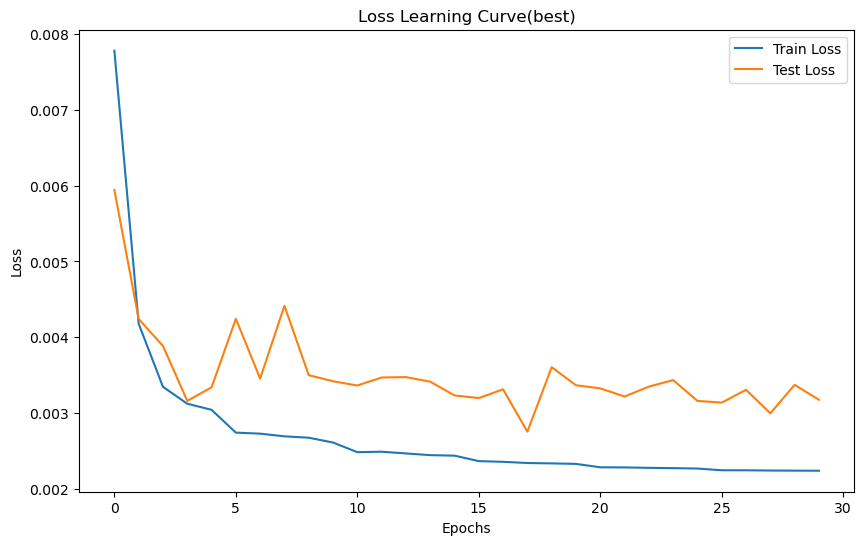

In [24]:
plot_loss(best_trial_df)

### LSTM RayTune結果

#### LSTM 1層

In [25]:
# モデル定義
# 乱数シード設定
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # 最後の時間ステップを出力
        return out

In [26]:
exp_name = "LSTM_tune_1"
storage_path = os.path.abspath("ray_results")
experiment_path = os.path.join(storage_path, exp_name) # 実験ディレクトリのパスを指定
os.makedirs(experiment_path, exist_ok=True) # すでにディレクトリが存在している場合はスキップ

# ハイパーパラメータ探索範囲
config = {
    "hidden_size": tune.choice([64, 128, 256]),
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "dropout": tune.uniform(0.0, 0.5),
    "batch_size": tune.choice([64, 128]),
    "num_epochs": 30
}

# 試行スケジューラ定義
ray_scheduler = ASHAScheduler(
    max_t=30,
    grace_period=5,
    reduction_factor=2
)

def train_lstm1_model(config):
    set_seed(42)
    device = "cuda" if torch.cuda.is_available() else "cpu"  # GPUが利用可能なら使用
    train_loader, test_loader = create_dataloaders(config["batch_size"])

    model = LSTMModel(
        input_size=6,  # 特徴量数に合わせる
        hidden_size=config["hidden_size"],
        output_size=1,  # 出力サイズ
        num_layers=1, # ここを変える
        dropout=config["dropout"]
    ).to(device)  # モデルをGPUに送る

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    best_test_loss = float("inf")
    best_epoch = 0
    best_model_state = None

    for epoch in range(config["num_epochs"]):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets = [], []
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 入力データをGPUに送る

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_predictions.append(outputs.cpu())  # CPUに戻す
            train_targets.append(batch_y.cpu())

        train_loss /= len(train_loader)
        train_predictions = scaler_y.inverse_transform(torch.cat(train_predictions).detach().numpy()) # 勾配追跡を無効化
        train_targets = scaler_y.inverse_transform(torch.cat(train_targets).detach().numpy())
        train_rmse = np.sqrt(mean_squared_error(train_targets, train_predictions))

        model.eval()
        test_loss = 0.0
        test_predictions, test_targets = [], []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
                test_predictions.append(outputs.cpu())  # CPUに戻す
                test_targets.append(batch_y.cpu())

        test_loss /= len(test_loader)
        test_predictions = scaler_y.inverse_transform(torch.cat(test_predictions).detach().numpy())
        test_targets = scaler_y.inverse_transform(torch.cat(test_targets).detach().numpy())
        test_rmse = np.sqrt(mean_squared_error(test_targets, test_predictions))
        test_r2 = r2_score(test_targets, test_predictions)

        if test_loss < best_test_loss:
          best_test_loss = test_loss
          best_epoch = epoch
          best_model_state = model.state_dict()

        # 学習率スケジューラを更新
        scheduler.step()

        # 結果を報告
        tune.report({"train_loss": train_loss, "train_rmse": train_rmse,
                        "test_loss": test_loss, "test_rmse": test_rmse,
                        "test_r2": test_r2,
                        "epoch": epoch, "best_test_loss": best_test_loss, "best_epoch":best_epoch})

    torch.save(best_model_state, os.path.join(experiment_path, "best_model.path"))

algo = OptunaSearch(metric="test_loss", mode="min")

# リソース設定
scaling_config = ScalingConfig(
    num_workers=-2,              # 試行ごとに使用するワーカー数
    use_gpu=True,               # GPUを使用
    trainer_resources={"cpu": 4, "gpu": 1},  # トレーナーが使用するリソース
)
trainable_with_cpu_gpu = tune.with_resources(train_lstm1_model, {"cpu": 4, "gpu": 1})
tuner = tune.Tuner(
    trainable_with_cpu_gpu,
    tune_config=tune.TuneConfig(
        metric="test_loss",
        mode="min",
        num_samples=30,
        search_alg=algo,
        scheduler=ray_scheduler,
        max_concurrent_trials=5
    ),
    run_config=RunConfig(
        storage_path=experiment_path,
        verbose=1,
    ),
    param_space=config,
)
result_grid = tuner.fit()
best_result = result_grid.get_best_result()

2025-05-25 01:02:51,501	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/omen/Projects/2505_portfolio_r/ray_results/LSTM_tune_1/train_lstm1_model_2025-05-25_00-48-45' in 0.0052s.
2025-05-25 01:02:51,508	INFO tune.py:1041 -- Total run time: 846.14 seconds (845.95 seconds for the tuning loop).


In [27]:
best_config  = best_result.config
best_metrics = best_result.metrics
print(best_result)
print("Best config:", best_config)
print("Best metrics:", best_metrics)

Result(
  metrics={'train_loss': 0.0019462142602436735, 'train_rmse': np.float64(178.80182268890604), 'test_loss': 0.0030289668378243426, 'test_rmse': np.float64(222.8499179661056), 'test_r2': 0.9022414684295654, 'epoch': 29, 'best_test_loss': 0.0026687730331463318, 'best_epoch': 14},
  path='/home/omen/Projects/2505_portfolio_r/ray_results/LSTM_tune_1/train_lstm1_model_2025-05-25_00-48-45/train_lstm1_model_2782a4ab_25_batch_size=64,dropout=0.1656,hidden_size=256,learning_rate=0.0006,num_epochs=30_2025-05-25_00-59-01',
  filesystem='local',
  checkpoint=None
)
Best config: {'hidden_size': 256, 'learning_rate': 0.0006023549726693999, 'dropout': 0.16555315028945927, 'batch_size': 64, 'num_epochs': 30}
Best metrics: {'train_loss': 0.0019462142602436735, 'train_rmse': np.float64(178.80182268890604), 'test_loss': 0.0030289668378243426, 'test_rmse': np.float64(222.8499179661056), 'test_r2': 0.9022414684295654, 'epoch': 29, 'best_test_loss': 0.0026687730331463318, 'best_epoch': 14, 'timestamp

In [28]:
analysis = get_json("train_lstm1_model")

In [29]:
# 最良試行のデータフレームを取得
best_trial = analysis.get_best_trial(metric="test_loss", mode="min")
best_trial_df = analysis.trial_dataframes[best_trial.trial_id]

# test_loss が最小のエポックを取得
best_epoch_idx = best_trial_df["test_loss"].idxmin()
best_epoch = best_trial_df.loc[best_epoch_idx]

# 同じエポックの test_rmse, test_r2 を取得
best_epoch_loss = best_epoch["test_loss"]
best_epoch_rmse = best_epoch["test_rmse"]
best_epoch_r2 = best_epoch["test_r2"]

# 結果を表示
print(f"Best Epoch: {best_epoch['epoch']}")
print(f"Best Test Loss: {best_epoch_loss}")
print(f"Best Test RMSE: {best_epoch_rmse}")
print(f"Best Test R²: {best_epoch_r2}")

Best Epoch: 14
Best Test Loss: 0.0026687730331463318
Best Test RMSE: 209.64533853331918
Best Test R²: 0.9134832620620728


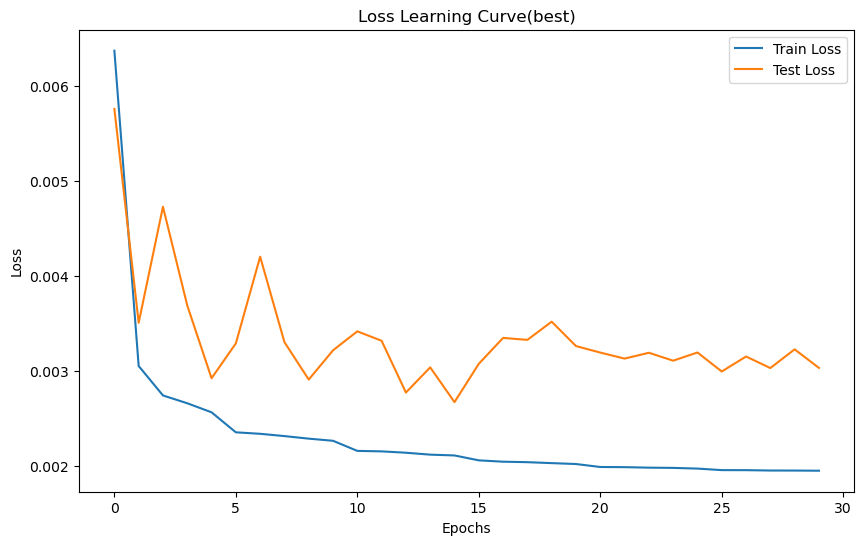

In [31]:
plot_loss(best_trial_df)

#### LSTM 2層

In [32]:
exp_name = "LSTM_tune_2"
storage_path = os.path.abspath("ray_results")
experiment_path = os.path.join(storage_path, exp_name) # 実験ディレクトリのパスを指定
os.makedirs(experiment_path, exist_ok=True) # すでにディレクトリが存在している場合はスキップ

# ハイパーパラメータ探索範囲
config = {
    "hidden_size": tune.choice([64, 128, 256]),
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "dropout": tune.uniform(0.0, 0.5),
    "batch_size": tune.choice([64, 128]),
    "num_epochs": 30
}

# 試行スケジューラ定義
ray_scheduler = ASHAScheduler(
    max_t=30,
    grace_period=5,
    reduction_factor=2
)

def train_lstm2_model(config):
    set_seed(42)
    device = "cuda" if torch.cuda.is_available() else "cpu"  # GPUが利用可能なら使用
    train_loader, test_loader = create_dataloaders(config["batch_size"])

    model = LSTMModel(
        input_size=6,  # 特徴量数に合わせる
        hidden_size=config["hidden_size"],
        output_size=1,  # 出力サイズ
        num_layers=2, # ここを変える
        dropout=config["dropout"]
    ).to(device)  # モデルをGPUに送る

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    best_test_loss = float("inf")
    best_epoch = 0
    best_model_state = None

    for epoch in range(config["num_epochs"]):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets = [], []
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 入力データをGPUに送る

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_predictions.append(outputs.cpu())  # CPUに戻す
            train_targets.append(batch_y.cpu())

        train_loss /= len(train_loader)
        train_predictions = scaler_y.inverse_transform(torch.cat(train_predictions).detach().numpy()) # 勾配追跡を無効化
        train_targets = scaler_y.inverse_transform(torch.cat(train_targets).detach().numpy())
        train_rmse = np.sqrt(mean_squared_error(train_targets, train_predictions))

        model.eval()
        test_loss = 0.0
        test_predictions, test_targets = [], []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
                test_predictions.append(outputs.cpu())  # CPUに戻す
                test_targets.append(batch_y.cpu())

        test_loss /= len(test_loader)
        test_predictions = scaler_y.inverse_transform(torch.cat(test_predictions).detach().numpy())
        test_targets = scaler_y.inverse_transform(torch.cat(test_targets).detach().numpy())
        test_rmse = np.sqrt(mean_squared_error(test_targets, test_predictions))
        test_r2 = r2_score(test_targets, test_predictions)

        if test_loss < best_test_loss:
          best_test_loss = test_loss
          best_epoch = epoch
          best_model_state = model.state_dict()

        # 学習率スケジューラを更新
        scheduler.step()

        # 結果を報告
        tune.report({"train_loss": train_loss, "train_rmse": train_rmse,
                        "test_loss": test_loss, "test_rmse": test_rmse,
                        "test_r2": test_r2,
                        "epoch": epoch, "best_test_loss": best_test_loss, "best_epoch":best_epoch})

    torch.save(best_model_state, os.path.join(experiment_path, "best_model.path"))

algo = OptunaSearch(metric="test_loss", mode="min")

# リソース設定
scaling_config = ScalingConfig(
    num_workers=-2,              # 試行ごとに使用するワーカー数
    use_gpu=True,               # GPUを使用
    trainer_resources={"cpu": 4, "gpu": 1},  # トレーナーが使用するリソース
)
trainable_with_cpu_gpu = tune.with_resources(train_lstm2_model, {"cpu": 4, "gpu": 1})
tuner = tune.Tuner(
    trainable_with_cpu_gpu,
    tune_config=tune.TuneConfig(
        metric="test_loss",
        mode="min",
        num_samples=30,
        search_alg=algo,
        scheduler=ray_scheduler,
        max_concurrent_trials=5
    ),
    run_config=RunConfig(
        storage_path=experiment_path,
        verbose=1,
    ),
    param_space=config,
)
result_grid = tuner.fit()
best_result = result_grid.get_best_result()

2025-05-25 01:13:02,513	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/omen/Projects/2505_portfolio_r/ray_results/LSTM_tune_2/train_lstm2_model_2025-05-25_01-02-51' in 0.0084s.
2025-05-25 01:13:02,520	INFO tune.py:1041 -- Total run time: 610.85 seconds (610.66 seconds for the tuning loop).


In [33]:
best_config  = best_result.config
best_metrics = best_result.metrics
print(best_result)
print("Best config:", best_config)
print("Best metrics:", best_metrics)

Result(
  metrics={'train_loss': 0.0021929211203448344, 'train_rmse': np.float64(189.79647816806295), 'test_loss': 0.0029642421033476357, 'test_rmse': np.float64(220.0341681563343), 'test_r2': 0.9046962857246399, 'epoch': 19, 'best_test_loss': 0.002852741300729036, 'best_epoch': 5},
  path='/home/omen/Projects/2505_portfolio_r/ray_results/LSTM_tune_2/train_lstm2_model_2025-05-25_01-02-51/train_lstm2_model_2354e809_3_batch_size=128,dropout=0.4072,hidden_size=128,learning_rate=0.0010,num_epochs=30_2025-05-25_01-04-00',
  filesystem='local',
  checkpoint=None
)
Best config: {'hidden_size': 128, 'learning_rate': 0.0010360597403329722, 'dropout': 0.407173287582553, 'batch_size': 128, 'num_epochs': 30}
Best metrics: {'train_loss': 0.0021929211203448344, 'train_rmse': np.float64(189.79647816806295), 'test_loss': 0.0029642421033476357, 'test_rmse': np.float64(220.0341681563343), 'test_r2': 0.9046962857246399, 'epoch': 19, 'best_test_loss': 0.002852741300729036, 'best_epoch': 5, 'timestamp': 17

In [34]:
analysis = get_json("train_lstm2_model")

In [35]:
# 最良試行のデータフレームを取得
best_trial = analysis.get_best_trial(metric="test_loss", mode="min")
best_trial_df = analysis.trial_dataframes[best_trial.trial_id]

# test_loss が最小のエポックを取得
best_epoch_idx = best_trial_df["test_loss"].idxmin()
best_epoch = best_trial_df.loc[best_epoch_idx]

# 同じエポックの test_rmse, test_r2 を取得
best_epoch_loss = best_epoch["test_loss"]
best_epoch_rmse = best_epoch["test_rmse"]
best_epoch_r2 = best_epoch["test_r2"]

# 結果を表示
print(f"Best Epoch: {best_epoch['epoch']}")
print(f"Best Test Loss: {best_epoch_loss}")
print(f"Best Test RMSE: {best_epoch_rmse}")
print(f"Best Test R²: {best_epoch_r2}")

Best Epoch: 5
Best Test Loss: 0.002852741300729036
Best Test RMSE: 216.31279796281126
Best Test R²: 0.9078927040100098


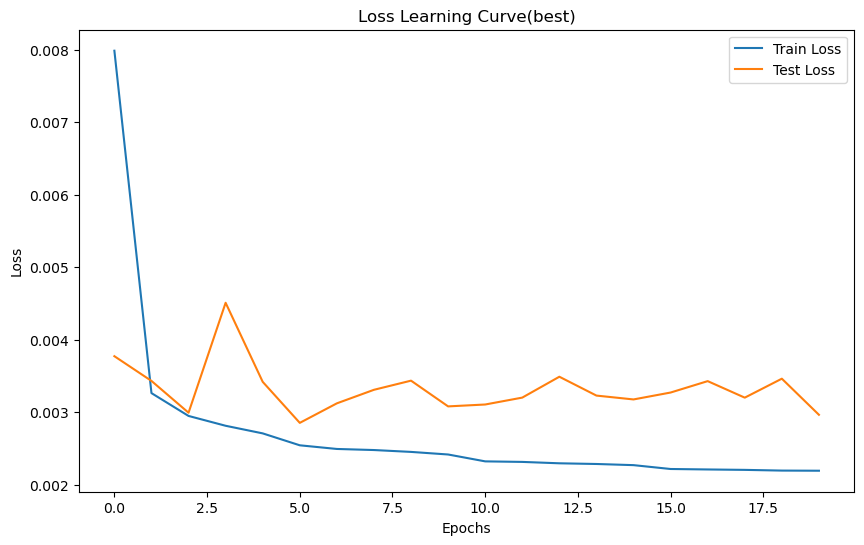

In [37]:
plot_loss(best_trial_df)

### GRU RayTune結果

#### GRU 1層

In [38]:
# 乱数シード設定
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# モデル定義
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.0):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :]) # 最後の時間ステップを出力
        return out

In [39]:
exp_name = "GRU_tune_1"
storage_path = os.path.abspath("ray_results")
experiment_path = os.path.join(storage_path, exp_name) # 実験ディレクトリのパスを指定
os.makedirs(experiment_path, exist_ok=True) # すでにディレクトリが存在している場合はスキップ

# ハイパーパラメータ探索範囲
config = {
    "hidden_size": tune.choice([64, 128, 256]),
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "dropout": tune.uniform(0.0, 0.5),
    "batch_size": tune.choice([64, 128]),
    "num_epochs": 30
}

# 試行スケジューラ定義
ray_scheduler = ASHAScheduler(
    max_t=30,
    grace_period=5,
    reduction_factor=2
)

def train_gru1_model(config):
    set_seed(42)
    device = "cuda" if torch.cuda.is_available() else "cpu"  # GPUが利用可能なら使用
    train_loader, test_loader = create_dataloaders(config["batch_size"])

    model = GRUModel(
        input_size=6,  # 特徴量数に合わせる
        hidden_size=config["hidden_size"],
        output_size=1,  # 出力サイズ
        num_layers=1, # ここを変える
        dropout=config["dropout"]
    ).to(device)  # モデルをGPUに送る

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    best_test_loss = float("inf")
    best_epoch = 0
    best_model_state = None

    for epoch in range(config["num_epochs"]):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets = [], []
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 入力データをGPUに送る

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_predictions.append(outputs.cpu())  # CPUに戻す
            train_targets.append(batch_y.cpu())

        train_loss /= len(train_loader)
        train_predictions = scaler_y.inverse_transform(torch.cat(train_predictions).detach().numpy()) # 勾配追跡を無効化
        train_targets = scaler_y.inverse_transform(torch.cat(train_targets).detach().numpy())
        train_rmse = np.sqrt(mean_squared_error(train_targets, train_predictions))

        model.eval()
        test_loss = 0.0
        test_predictions, test_targets = [], []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
                test_predictions.append(outputs.cpu())  # CPUに戻す
                test_targets.append(batch_y.cpu())

        test_loss /= len(test_loader)
        test_predictions = scaler_y.inverse_transform(torch.cat(test_predictions).detach().numpy())
        test_targets = scaler_y.inverse_transform(torch.cat(test_targets).detach().numpy())
        test_rmse = np.sqrt(mean_squared_error(test_targets, test_predictions))
        test_r2 = r2_score(test_targets, test_predictions)

        if test_loss < best_test_loss:
          best_test_loss = test_loss
          best_epoch = epoch
          best_model_state = model.state_dict()

        # 学習率スケジューラを更新
        scheduler.step()

        # 結果を報告
        tune.report({"train_loss": train_loss, "train_rmse": train_rmse,
                        "test_loss": test_loss, "test_rmse": test_rmse,
                        "test_r2": test_r2,
                        "epoch": epoch, "best_test_loss": best_test_loss, "best_epoch":best_epoch})

    torch.save(best_model_state, os.path.join(experiment_path, "best_model.path"))

algo = OptunaSearch(metric="test_loss", mode="min")

# リソース設定
scaling_config = ScalingConfig(
    num_workers=-2,              # 試行ごとに使用するワーカー数
    use_gpu=True,               # GPUを使用
    trainer_resources={"cpu": 4, "gpu": 1},  # トレーナーが使用するリソース
)
trainable_with_cpu_gpu = tune.with_resources(train_gru1_model, {"cpu": 4, "gpu": 1})
tuner = tune.Tuner(
    trainable_with_cpu_gpu,
    tune_config=tune.TuneConfig(
        metric="test_loss",
        mode="min",
        num_samples=30,
        search_alg=algo,
        scheduler=ray_scheduler,
        max_concurrent_trials=5
    ),
    run_config=RunConfig(
        storage_path=experiment_path,
        verbose=1,
    ),
    param_space=config,
)
result_grid = tuner.fit()
best_result = result_grid.get_best_result()

2025-05-25 01:24:25,767	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/omen/Projects/2505_portfolio_r/ray_results/GRU_tune_1/train_gru1_model_2025-05-25_01-13-02' in 0.0069s.
2025-05-25 01:24:25,774	INFO tune.py:1041 -- Total run time: 683.07 seconds (682.90 seconds for the tuning loop).


In [40]:
best_config  = best_result.config
best_metrics = best_result.metrics
print(best_result)
print("Best config:", best_config)
print("Best metrics:", best_metrics)

Result(
  metrics={'train_loss': 0.0021760084714692136, 'train_rmse': np.float64(189.06316115586876), 'test_loss': 0.002793921069984419, 'test_rmse': np.float64(213.3778741751356), 'test_r2': 0.91037517786026, 'epoch': 9, 'best_test_loss': 0.002599519815808837, 'best_epoch': 7},
  path='/home/omen/Projects/2505_portfolio_r/ray_results/GRU_tune_1/train_gru1_model_2025-05-25_01-13-02/train_gru1_model_d44eea62_6_batch_size=128,dropout=0.3949,hidden_size=256,learning_rate=0.0019,num_epochs=30_2025-05-25_01-14-32',
  filesystem='local',
  checkpoint=None
)
Best config: {'hidden_size': 256, 'learning_rate': 0.0019492504073061303, 'dropout': 0.3949096982026997, 'batch_size': 128, 'num_epochs': 30}
Best metrics: {'train_loss': 0.0021760084714692136, 'train_rmse': np.float64(189.06316115586876), 'test_loss': 0.002793921069984419, 'test_rmse': np.float64(213.3778741751356), 'test_r2': 0.91037517786026, 'epoch': 9, 'best_test_loss': 0.002599519815808837, 'best_epoch': 7, 'timestamp': 1748103307, 

In [41]:
analysis = get_json("train_gru1_model")

In [42]:
# 最良試行のデータフレームを取得
best_trial = analysis.get_best_trial(metric="test_loss", mode="min")
best_trial_df = analysis.trial_dataframes[best_trial.trial_id]

# test_loss が最小のエポックを取得
best_epoch_idx = best_trial_df["test_loss"].idxmin()
best_epoch = best_trial_df.loc[best_epoch_idx]

# 同じエポックの test_rmse, test_r2 を取得
best_epoch_loss = best_epoch["test_loss"]
best_epoch_rmse = best_epoch["test_rmse"]
best_epoch_r2 = best_epoch["test_r2"]

# 結果を表示
print(f"Best Epoch: {best_epoch['epoch']}")
print(f"Best Test Loss: {best_epoch_loss}")
print(f"Best Test RMSE: {best_epoch_rmse}")
print(f"Best Test R²: {best_epoch_r2}")

Best Epoch: 7
Best Test Loss: 0.002599519815808837
Best Test RMSE: 204.13186034093258
Best Test R²: 0.917974054813385


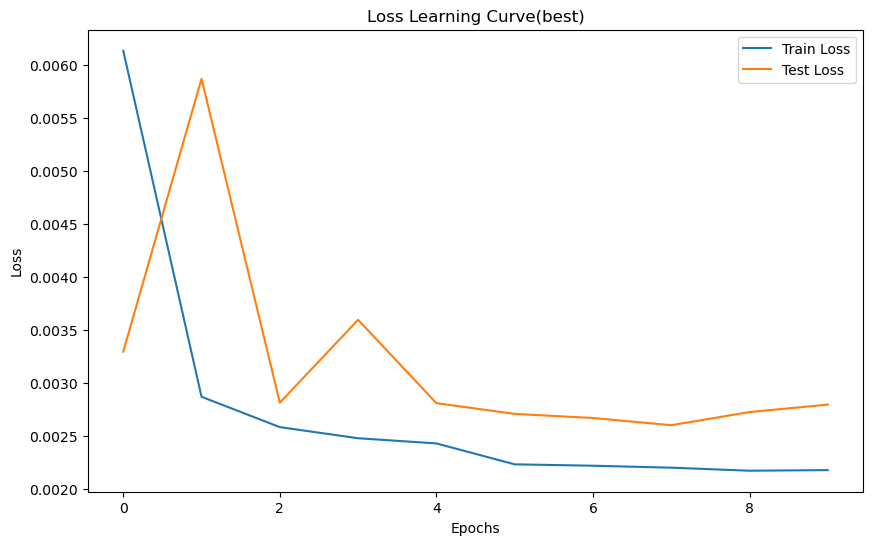

In [44]:
plot_loss(best_trial_df)

#### GRU 2層

In [45]:
exp_name = "GRU_tune_2"
storage_path = os.path.abspath("ray_results")
experiment_path = os.path.join(storage_path, exp_name) # 実験ディレクトリのパスを指定
os.makedirs(experiment_path, exist_ok=True) # すでにディレクトリが存在している場合はスキップ

# ハイパーパラメータ探索範囲
config = {
    "hidden_size": tune.choice([64, 128]), # メモリが不足するため256を削除
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "dropout": tune.uniform(0.0, 0.5),
    "batch_size": tune.choice([64, 128]),
    "num_epochs": 30
}

# 試行スケジューラ定義
ray_scheduler = ASHAScheduler(
    max_t=30,
    grace_period=5,
    reduction_factor=4
)

def train_gru2_model(config):
    set_seed(42)
    device = "cuda" if torch.cuda.is_available() else "cpu"  # GPUが利用可能なら使用
    train_loader, test_loader = create_dataloaders(config["batch_size"])

    model = GRUModel(
        input_size=6,  # 特徴量数に合わせる
        hidden_size=config["hidden_size"],
        output_size=1,  # 出力サイズ
        num_layers=2, # ここを変える
        dropout=config["dropout"]
    ).to(device)  # モデルをGPUに送る

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    best_test_loss = float("inf")
    best_epoch = 0
    best_model_state = None

    for epoch in range(config["num_epochs"]):
        model.train()
        train_loss = 0.0
        train_predictions, train_targets = [], []
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)  # 入力データをGPUに送る

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_predictions.append(outputs.cpu())  # CPUに戻す
            train_targets.append(batch_y.cpu())

        train_loss /= len(train_loader)
        train_predictions = scaler_y.inverse_transform(torch.cat(train_predictions).detach().numpy()) # 勾配追跡を無効化
        train_targets = scaler_y.inverse_transform(torch.cat(train_targets).detach().numpy())
        train_rmse = np.sqrt(mean_squared_error(train_targets, train_predictions))

        model.eval()
        test_loss = 0.0
        test_predictions, test_targets = [], []
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
                test_predictions.append(outputs.cpu())  # CPUに戻す
                test_targets.append(batch_y.cpu())

        test_loss /= len(test_loader)
        test_predictions = scaler_y.inverse_transform(torch.cat(test_predictions).detach().numpy())
        test_targets = scaler_y.inverse_transform(torch.cat(test_targets).detach().numpy())
        test_rmse = np.sqrt(mean_squared_error(test_targets, test_predictions))
        test_r2 = r2_score(test_targets, test_predictions)

        if test_loss < best_test_loss:
          best_test_loss = test_loss
          best_epoch = epoch
          best_model_state = model.state_dict()

        # 学習率スケジューラを更新
        scheduler.step()

        # 結果を報告
        tune.report({"train_loss": train_loss, "train_rmse": train_rmse,
                        "test_loss": test_loss, "test_rmse": test_rmse,
                        "test_r2": test_r2,
                        "epoch": epoch, "best_test_loss": best_test_loss, "best_epoch":best_epoch})

    torch.save(best_model_state, os.path.join(experiment_path, "best_model.path"))

algo = OptunaSearch(metric="test_loss", mode="min")

# リソース設定
scaling_config = ScalingConfig(
    num_workers=-2,              # 試行ごとに使用するワーカー数
    use_gpu=True,               # GPUを使用
    trainer_resources={"cpu": 4, "gpu": 1},  # トレーナーが使用するリソース
)
trainable_with_cpu_gpu = tune.with_resources(train_gru2_model, {"cpu": 4, "gpu": 1})
tuner = tune.Tuner(
    trainable_with_cpu_gpu,
    tune_config=tune.TuneConfig(
        metric="test_loss",
        mode="min",
        num_samples=30,
        search_alg=algo,
        scheduler=ray_scheduler,
        max_concurrent_trials=5
    ),
    run_config=RunConfig(
        storage_path=experiment_path,
        verbose=1,
    ),
    param_space=config,
)
result_grid = tuner.fit()
best_result = result_grid.get_best_result()

2025-05-25 01:36:04,931	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/omen/Projects/2505_portfolio_r/ray_results/GRU_tune_2/train_gru2_model_2025-05-25_01-24-25' in 0.0059s.
2025-05-25 01:36:04,937	INFO tune.py:1041 -- Total run time: 698.99 seconds (698.82 seconds for the tuning loop).


In [46]:
best_config  = best_result.config
best_metrics = best_result.metrics
print(best_result)
print("Best config:", best_config)
print("Best metrics:", best_metrics)

Result(
  metrics={'train_loss': 0.0020611333528239265, 'train_rmse': np.float64(184.00502073652774), 'test_loss': 0.002807889851375375, 'test_rmse': np.float64(215.27811771926565), 'test_r2': 0.9087717533111572, 'epoch': 29, 'best_test_loss': 0.002363709844243915, 'best_epoch': 11},
  path='/home/omen/Projects/2505_portfolio_r/ray_results/GRU_tune_2/train_gru2_model_2025-05-25_01-24-25/train_gru2_model_35e6e477_18_batch_size=128,dropout=0.3861,hidden_size=64,learning_rate=0.0026,num_epochs=30_2025-05-25_01-31-41',
  filesystem='local',
  checkpoint=None
)
Best config: {'hidden_size': 64, 'learning_rate': 0.0026418151594714495, 'dropout': 0.3861492070587778, 'batch_size': 128, 'num_epochs': 30}
Best metrics: {'train_loss': 0.0020611333528239265, 'train_rmse': np.float64(184.00502073652774), 'test_loss': 0.002807889851375375, 'test_rmse': np.float64(215.27811771926565), 'test_r2': 0.9087717533111572, 'epoch': 29, 'best_test_loss': 0.002363709844243915, 'best_epoch': 11, 'timestamp': 174

In [47]:
analysis = get_json("train_gru2_model")

In [49]:
# 最良試行のデータフレームを取得
best_trial = analysis.get_best_trial(metric="test_loss", mode="min")
best_trial_df = analysis.trial_dataframes[best_trial.trial_id]

# test_loss が最小のエポックを取得
best_epoch_idx = best_trial_df["test_loss"].idxmin()
best_epoch = best_trial_df.loc[best_epoch_idx]

# 同じエポックの test_rmse, test_r2 を取得
best_epoch_loss = best_epoch["test_loss"]
best_epoch_rmse = best_epoch["test_rmse"]
best_epoch_r2 = best_epoch["test_r2"]

# 結果を表示
print(f"Best Epoch: {best_epoch['epoch']}")
print(f"Best Test Loss: {best_epoch_loss}")
print(f"Best Test RMSE: {best_epoch_rmse}")
print(f"Best Test R²: {best_epoch_r2}")

Best Epoch: 11
Best Test Loss: 0.002363709844243915
Best Test RMSE: 197.14889677601548
Best Test R²: 0.9234899878501892


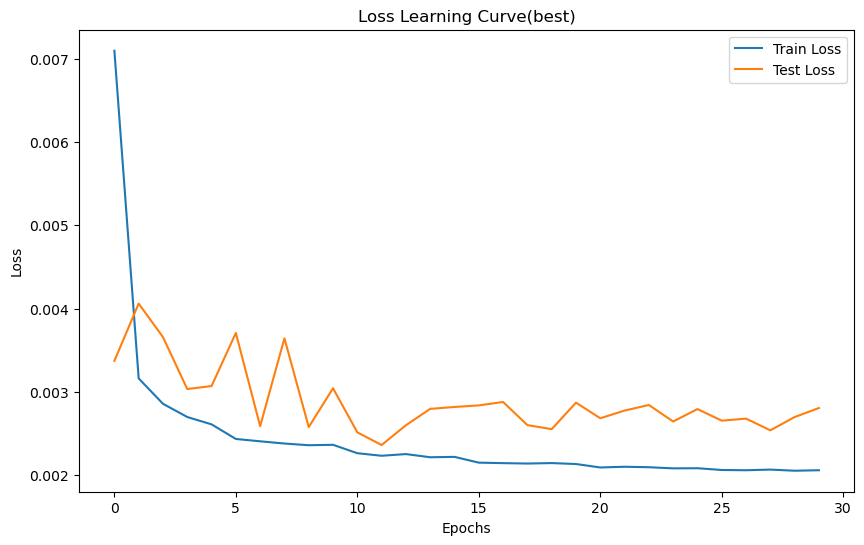

In [50]:
plot_loss(best_trial_df)

## 結果のまとめ

| Model | train_loss | train_rmse | test_loss | test_rmse | test_r2 | best_test_loss | best_test_rmse | best_test_r2 | hidden_size | learning_rate | dropout | batch_size |
| ----- | ---------- | ----------:| ---------:| ---------:| -------:| -------------:| --------------:| ------------:| -----------:| -------------:| -------:| ----------:|
| RNN   |      0.0022|    191.7667|     0.0032|    228.0010|   0.8977|         0.0028|       212.6791|       0.9110|          64|         0.0012|   0.2216|          64|
| LSTM1 |      0.0019|    178.8018|     0.0030|   222.8499 |   0.9022 |         0.0027|       209.6453|       0.9135|         256|         0.0006|   0.1656|         64|
| LSTM2 |      0.0022|    189.7965|     0.00296|   220.0342|   0.9047|         0.0027|       216.3128|       0.9079|         128|         0.0010|   0.4072|         128|
| GRU1  |      0.0022|    189.0632|     0.00279|   213.3779|   0.9104|         0.0026|       204.1319|       0.9180|         256|         0.0019|   0.3949|         128|
| **GRU2**  |      0.0021|    184.0050|     0.00281|   215.2781|   0.9088|         **0.0024**|       **197.1489**|       **0.9235**|          64|         0.0026|   0.3861|         128|

- 一つ一つパラメータ調整を行った結果、デフォルトの設定（学習率0.001、1層、隠れユニット数128、ドロップアウト0.0）から学習率を0.002に変更したGRUモデルで、決定係数0.913、平均平方根誤差210.199という結果が最良の結果であった。
- 今回、RayTuneを用いたパラメータチューニングを行った結果では同じくGRUモデルで**決定係数0.9235**、**平均平方根誤差197.149**という結果が出た。
- 前回、2層のGRUモデルを用いた際は性能が下がってしまい、過学習を防ぐ仕組みを適切に組み込めていなかったと思料する。